# Extract Patches

This notebook show how the patches are extracted from the TMAs using the annotations specified in */DLBCL-Morph/TMA/annotations.csv*.

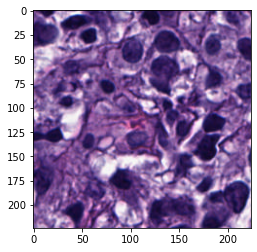

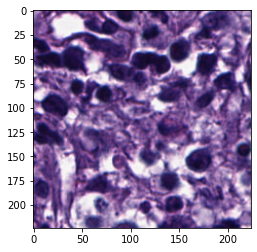

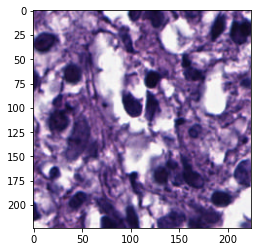

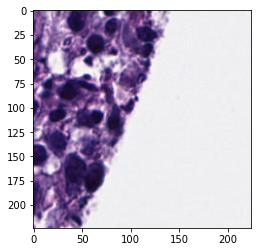

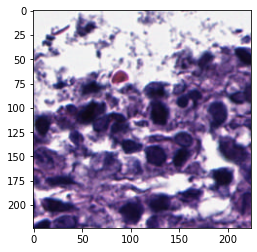

In [66]:
import openslide
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import h5py
import os


PATH_TO_DATASET = '/deep/group/aihc-bootcamp-winter2020/dlbcl/DLBCL-Morph/'  # Give the path to DLBCL-Morph
ANNOTATION_NUM = 5  # Select the annotation to extract patches from by specifying a row number from the DLBCL-Morph/TMA/annotations.csv
NUM_SAMPLES = 5  # Select the number of patches to show from the extracted patches (selected randomly)
PATCH_SIZE = 224  # Specify the size of the patches to extract from TMAs

PERCENT_WHITE_PIXELS_THRESHOLD = 0.95
SAT_THRESHOLD = 0.05
MAX_PIXEL_THRESHOLD = 500

np.random.seed(42)


def is_patch_nonwhite(patch, white_thresh, sat_thresh):
    hsv_patch = matplotlib.colors.rgb_to_hsv(patch)
    saturation = hsv_patch[:,:,1]
    percent = np.mean(saturation < SAT_THRESHOLD)
    return percent <= PERCENT_WHITE_PIXELS_THRESHOLD


def is_grad_nonzero(patch, max_pixel_threshold):
    gray = cv.cvtColor(np.array(patch), cv.COLOR_RGB2GRAY)
    sobelx = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=5)
    sobely = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=5)
    mag = np.abs(sobelx) + np.abs(sobely)
    return np.sum(mag == 0) <= max_pixel_threshold

    
def extract_tma_patches(slide, annotation):
    pat_id, tma_id, stain, xs, ys, xe, ye = annotation
    
    patches = []
    for y in range(ys, ye, PATCH_SIZE):
        for x in range(xs, xe, PATCH_SIZE):
            patch = slide.read_region([x, y], 0, [PATCH_SIZE, PATCH_SIZE]).convert('RGB')
            is_nonwhite = is_patch_nonwhite(patch, white_thresh=PERCENT_WHITE_PIXELS_THRESHOLD, sat_thresh=SAT_THRESHOLD)\
                    and is_grad_nonzero(patch, max_pixel_threshold=MAX_PIXEL_THRESHOLD)

            if is_nonwhite:
                patches.append(patch)
    
    return patches


def plot_samples(patches, num_samples=NUM_SAMPLES):
    if num_samples > len(patches):
        raise ValueError("Can not plot more samples than the number of patches there are.")
        
    indices = np.arange(len(patches))
    np.random.shuffle(indices)
    
    for i in range(num_samples):
        ii = indices[i]
        plt.imshow(patches[ii])
        plt.show()
        
    


if __name__=='__main__':
    path2annotations = os.path.join(PATH_TO_DATASET, 'TMA', 'annotations.csv')
    annotations = pd.read_csv(path2annotations)
    annotation = annotations.loc[ANNOTATION_NUM]
    
    path2tma = os.path.join(PATH_TO_DATASET, 'TMA', annotation['stain'], annotation['tma_id']+'.svs')
    slide = openslide.OpenSlide(path2tma)
    
    patches = extract_tma_patches(slide, annotation)
    plot_samples(patches)